In [1]:
from pyspark import SparkConf,SparkContext
from pyspark import rdd
conf=SparkConf().setMaster("local[*]").setAppName("First_APP")
sc=SparkContext(conf=conf)

广播变量（broadcast variable）为只读变量，它由运行SparkContext的驱动程序创建后发送给会参与计算的节点。对那些需要让各工作节点高效地访问相同数据的应用场景，比如机器学习

In [2]:
broadcastAList = sc.broadcast(list(["a", "b", "c", "d", "e"]))

In [3]:
sc.parallelize(list(["1", "2", "3"])).map(lambda x: broadcastAList.value).collect()

[['a', 'b', 'c', 'd', 'e'],
 ['a', 'b', 'c', 'd', 'e'],
 ['a', 'b', 'c', 'd', 'e']]

---------------------------------
1、探索用户数据
---------------------------------

In [4]:
user_data = sc.textFile('E:/machine_data/spark_test_data/ml-100k/u.user')
user_data.first()

'1|24|M|technician|85711'

下面用“|”字符来分隔各行数据。这将生成一个RDD,其中每一个记录对应一个Python列表,各列表由用户ID(user ID)、年龄(age)、性别(gender)、职业(occupation)和邮编(ZIP code)五个属性构成。4之后再统计用户、性别、职业和邮编的数目。

In [5]:
user_fields = user_data.map(lambda line: line.split('|'))
num_users = user_fields.map(lambda fields: fields[0]).count()   #统计用户数
num_genders = user_fields.map(lambda fields : fields[2]).distinct().count()   #统计性别个数
num_occupations = user_fields.map(lambda fields: fields[3]).distinct().count()   #统计职业个数
num_zipcodes = user_fields.map(lambda fields: fields[4]).distinct().count()   #统计邮编个数
print ("Users: %d, genders: %d, occupations: %d, ZIP codes: %d"%(num_users,num_genders,num_occupations,num_zipcodes))

Users: 943, genders: 2, occupations: 21, ZIP codes: 795


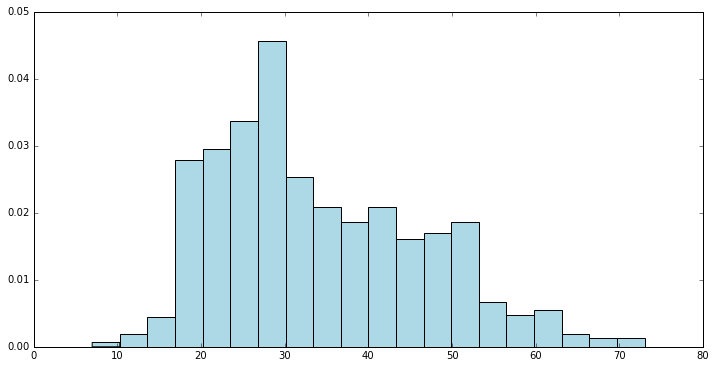

In [6]:
#画出用户的年龄分布图：
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import hist
ages = user_fields.map(lambda x: int(x[1])).collect()
hist(ages, bins=20, color='lightblue',normed=True)
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

[('engineer', 67), ('homemaker', 7), ('doctor', 7), ('administrator', 79), ('student', 196), ('programmer', 66), ('other', 105), ('executive', 32), ('retired', 14), ('artist', 28), ('none', 9), ('educator', 95), ('scientist', 31), ('lawyer', 12), ('writer', 45), ('technician', 27), ('librarian', 51), ('salesman', 12), ('healthcare', 16), ('marketing', 26), ('entertainment', 18)]


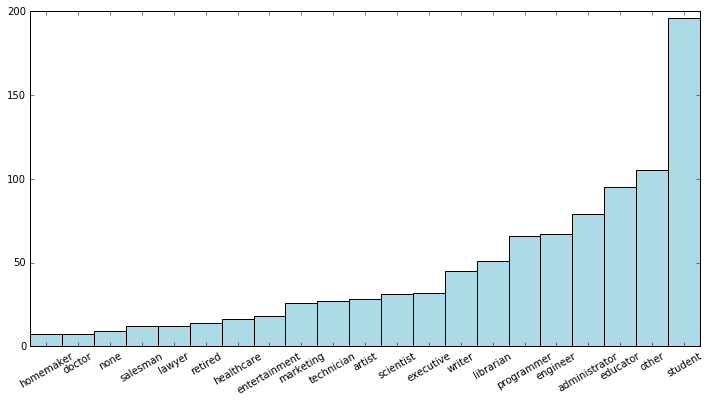

In [11]:
#画出用户的职业的分布图：

import numpy as np
count_by_occupation = user_fields.map(lambda fields: (fields[3],1)).reduceByKey(lambda x,y:x+y).collect()
print (count_by_occupation)
x_axis1 = np.array([c[0] for c in count_by_occupation])
y_axis1 = np.array([c[1] for c in count_by_occupation])
x_axis = x_axis1[np.argsort(y_axis1)]
y_axis = y_axis1[np.argsort(y_axis1)]
pos = np.arange(len(x_axis))
width = 1.0
ax = plt.axes()
ax.set_xticks(pos+(width)/2)
ax.set_xticklabels(x_axis)

plt.bar(pos, y_axis, width, color='lightblue')
plt.xticks(rotation=30)
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

In [12]:
#也可以通过countByValue()来统计职业种类个数
count_by_occupation2 = user_fields.map(lambda fields: fields[3]).countByValue()
print ("Map-reduce approach:")
print (dict(count_by_occupation))
print ("========================" )
print ("countByValue approach:")
print (dict(count_by_occupation2))

Map-reduce approach:
{'entertainment': 18, 'salesman': 12, 'executive': 32, 'educator': 95, 'retired': 14, 'student': 196, 'artist': 28, 'scientist': 31, 'marketing': 26, 'programmer': 66, 'homemaker': 7, 'technician': 27, 'engineer': 67, 'administrator': 79, 'writer': 45, 'doctor': 7, 'none': 9, 'healthcare': 16, 'lawyer': 12, 'librarian': 51, 'other': 105}
countByValue approach:
{'salesman': 12, 'executive': 32, 'student': 196, 'artist': 28, 'scientist': 31, 'librarian': 51, 'programmer': 66, 'writer': 45, 'doctor': 7, 'none': 9, 'educator': 95, 'lawyer': 12, 'other': 105, 'entertainment': 18, 'homemaker': 7, 'retired': 14, 'technician': 27, 'engineer': 67, 'marketing': 26, 'healthcare': 16, 'administrator': 79}


------------------------------
2、探索电影数据
------------------------------

In [13]:
movie_data = sc.textFile("E:/machine_data/spark_test_data/ml-100k/u.item")
print (movie_data.first())
num_movies = movie_data.count()
print ('Movies: %d' % num_movies)

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
Movies: 1682


绘制电影的age分布图：
绘制电影年龄的分布图的方法和之前对用户年龄和职业分布的处理类似。电影年龄即其发行年份相对于现在过了多少年(在本数据中现在是1998年)。从下面的代码可以看到,电影数据中有些数据不规整,故需要一个函数来处理解析releasedate时可能的解析错误。这里命名该函数为convert_year。


In [30]:
#画出电影的age分布图：

def convert_year(x):
    try:
        return int(x[-4:])
    except:
        return 1900

movie_fields = movie_data.map(lambda lines:lines.split('|'))
years = movie_fields.map(lambda fields: fields[2]).map(lambda x: convert_year(x))
years_filtered = years.filter(lambda x: x!=1900)
print (years_filtered.count())
movie_ages = years_filtered.map(lambda yr:1998-yr).countByValue()
values = movie_ages.values()
bins = movie_ages.keys()

1681


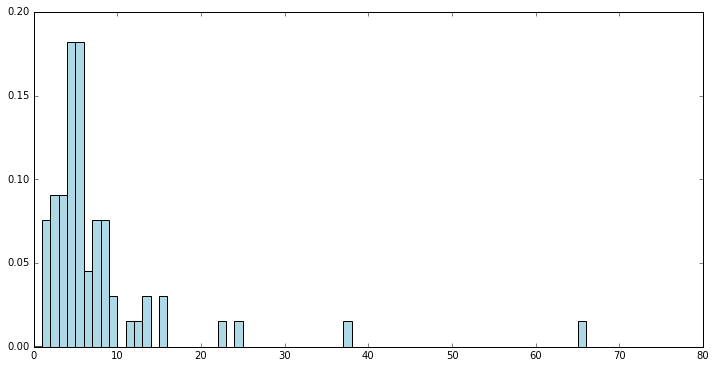

In [38]:
values=list(values)
bins=list(bins)
hist(values,bins=bins,color='lightblue',normed=True)
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

In [18]:
movie_fields.first()

['1',
 'Toy Story (1995)',
 '01-Jan-1995',
 '',
 'http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0']

In [19]:
years.first()

1995

In [20]:
years_filtered.count()

1681

In [25]:
print (movie_ages)
print (bins)
print (values)

defaultdict(<class 'int'>, {0: 65, 1: 286, 2: 355, 3: 219, 4: 214, 5: 126, 6: 37, 7: 22, 8: 24, 9: 15, 10: 11, 11: 13, 12: 15, 13: 7, 14: 8, 15: 5, 16: 13, 17: 12, 18: 8, 19: 9, 20: 4, 21: 4, 22: 5, 23: 6, 24: 8, 25: 4, 26: 3, 27: 7, 28: 3, 29: 4, 30: 6, 31: 5, 32: 2, 33: 5, 34: 2, 35: 6, 36: 5, 37: 3, 38: 5, 39: 4, 40: 9, 41: 8, 42: 4, 43: 5, 44: 7, 45: 2, 46: 3, 47: 5, 48: 7, 49: 4, 50: 3, 51: 5, 52: 5, 53: 4, 54: 5, 55: 4, 56: 2, 57: 5, 58: 8, 59: 7, 60: 3, 61: 4, 62: 2, 63: 4, 64: 4, 65: 2, 66: 1, 67: 1, 68: 1, 72: 1, 76: 1})
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 72, 76])
dict_values([65, 286, 355, 219, 214, 126, 37, 22, 24, 15, 11, 13, 15, 7, 8, 5, 13, 12, 8, 9, 4, 4, 5, 6, 8, 4, 3, 7, 3, 4, 6, 5, 2, 5, 2, 6, 5, 3, 5, 4, 9, 8, 4, 5, 7, 2, 3, 5, 7

---------------------------------
探索评分数据
---------------------------------

In [39]:
rating_data = sc.textFile('E:/machine_data/spark_test_data/ml-100k/u.data')
print (rating_data.first())
num_ratings = rating_data.count()
print ('Ratings: %d'% num_ratings)

196	242	3	881250949
Ratings: 100000


In [40]:
rating_data = rating_data.map(lambda line: line.split('\t')) #\t表示多个空格
ratings = rating_data.map(lambda fields: int(fields[2]))
max_rating = ratings.reduce(lambda x,y:max(x,y))
min_rating = ratings.reduce(lambda x,y:min(x,y))
mean_rating = ratings.reduce(lambda x,y:x+y)/num_ratings
median_rating = np.median(ratings.collect())
ratings_per_user = num_ratings/num_users;
ratings_per_movie = num_ratings/ num_movies
print ('Min rating: %d' %min_rating)
print ('max rating: %d' % max_rating)
print ('Average rating: %2.2f' %mean_rating)
print ('Median rating: %d '%median_rating)
print ('Average # of ratings per user: %2.2f'%ratings_per_user)
print ('Average # of ratings per movie: %2.2f' % ratings_per_movie)

Min rating: 1
max rating: 5
Average rating: 3.53
Median rating: 4 
Average # of ratings per user: 106.04
Average # of ratings per movie: 59.45


In [41]:
#统计量
ratings.stats() 

(count: 100000, mean: 3.5298600000000024, stdev: 1.12566797076, max: 5.0, min: 1.0)

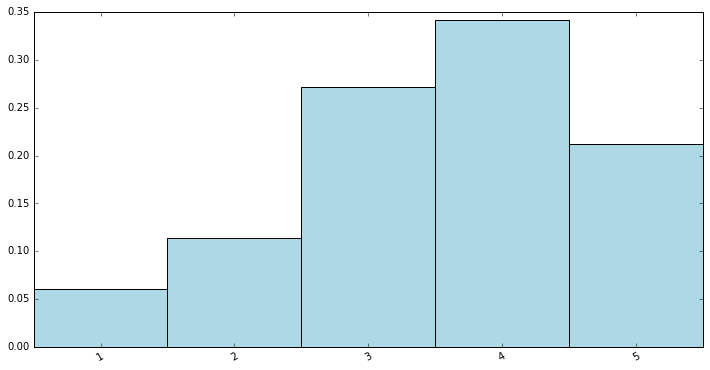

In [64]:
count_by_rating = ratings.countByValue()
x_axis = np.array(count_by_rating.keys())
y_axis = np.array([float(c) for c in count_by_rating.values()])
y_axis_normed = y_axis/y_axis.sum()
pos = np.array(range(len(x_axis.tolist())))
width = 1.0
ax = plt.axes()
ax.set_xticks(pos+(width/2))
ax.set_xticklabels(x_axis.tolist())

plt.bar(pos, y_axis_normed, width, color='lightblue')
plt.xticks(rotation=30)
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()


In [55]:
x_axis

array(dict_keys([1, 2, 3, 4, 5]), dtype=object)

In [59]:
len(x_axis.tolist())

5

接下来，计算每个用户和其对应的评价次数：

In [80]:
user_ratings_grouped = rating_data.map(lambda fields:(int(fields[0]),int(fields[2]))).groupByKey()

In [81]:
user_ratings_grouped.collect()[0:3]

[(2, <pyspark.resultiterable.ResultIterable at 0x1d1559f7b70>),
 (4, <pyspark.resultiterable.ResultIterable at 0x1d1559f7c18>),
 (6, <pyspark.resultiterable.ResultIterable at 0x1d1559f7588>)]

In [109]:
#测试一下.map(lambda (x,y):(x*y,x+y))的用法，python 3+ 将其换成了.map(lambda kv: (kv[0]*kv[1], kv[0]+kv[1])) 其中kv[i]表示第i个元素
a=[(1,2),(2,3)]
a=sc.parallelize(a)
a1=a.map(lambda x,y:(x*y,x+y))
print (type(a1))
b=[1,2,3,4]
b=sc.parallelize(b)
b1=b.map(lambda x:(x*2,x+1))
b1.collect()

<class 'pyspark.rdd.PipelinedRDD'>


[(2, 2), (4, 3), (6, 4), (8, 5)]

In [121]:
a2=a.map(lambda kv: (kv[0]*kv[1], kv[0]+kv[1]))

In [122]:
a2.collect()

[(2, 3), (6, 5)]

In [112]:
# Let's see how many partitions the RDD will be split into by using the getNumPartitions()
a1.getNumPartitions()

4

In [123]:
user_rating_byuser = user_ratings_grouped.map(lambda kv:(kv[0],len(kv[1])))
type (user_rating_byuser) #这里我们认识了一个新的数据类型pyspark.rdd.PipelinedRDD，为RDD子类型，可以用RDD的APIs


pyspark.rdd.PipelinedRDD

In [129]:
user_rating_byuser.take(4)

[(2, 62), (4, 24), (6, 211), (8, 59)]

注解：在这里我们看到，前面的key值都是偶数，这是因为根据分组 将所有值存入不同的内存区内，可以看出，此例中是根据key的奇偶来分的

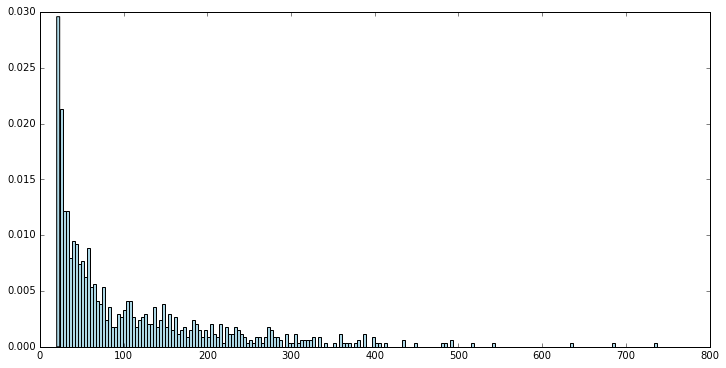

In [126]:
user_ratings_byuser_local = user_rating_byuser.map(lambda kv:kv[1]).collect()
hist(user_ratings_byuser_local, bins=200, color = 'lightblue',normed = True)
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

In [131]:
# 为每部电影计算他的被评论的次数
movie_ratings_group = rating_data.map(lambda fields: (int(fields[1]),int(fields[2]))).groupByKey()
movie_ratings_byuser = movie_ratings_group.map(lambda kv:(kv[0],len(kv[1])))
print (movie_ratings_byuser.take(5))

[(2, 131), (4, 209), (6, 26), (8, 219), (10, 89)]


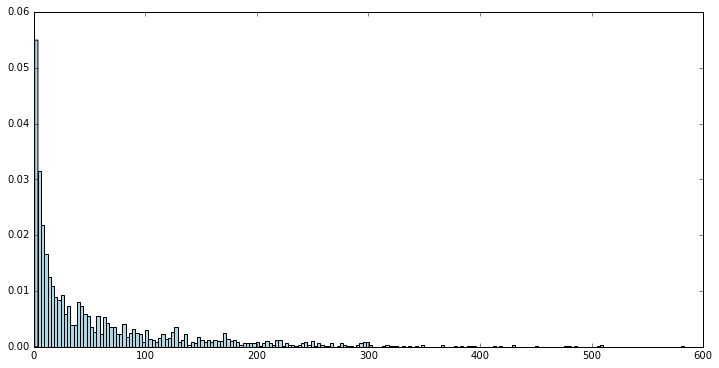

In [132]:
# 绘制电影评论次数分布图：
movie_ratings_byuser_local = movie_ratings_byuser.map(lambda kv:kv[1]).collect()
hist(movie_ratings_byuser_local,bins=200,color='lightblue',normed=True)
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

----------------------------
3、数据处理与转换
----------------------------

现在我们已对数据集进行过探索性的分析,并了解了用户和电影的一些特征。那接下来做什么呢?

为让原始数据可用于机器学习算法,需要先对其进行清理,并可能需要将其进行各种转换,之后才能从转换后的数据里提取有用的特征。数据的转换和特征提取联系紧密。某些情况下,一些转换本身便是特征提取的过程。

在之前处理电影数据集时我们已经看到数据清理的必要性。一般来说,现实中的数据会存在信息不规整、数据点缺失和异常值问题。理想情况下,我们会修复非规整数据。但很多数据集都源于一些难以重现的收集过程(比如网络活动数据和传感器数据),故实际上会难以修复。值缺失和异常也很常见,且处理方式可与处理非规整信息类似。总的来说,大致的处理方法如下。 

1、过滤掉或删除非规整或有值缺失的数据:这通常是必须的,但的确会损失这些数据里那些好的信息。

2、填充非规整或缺失的数据:可以根据其他的数据来填充非规整或缺失的数据。方法包括用零值、全局期望或中值来填充,或是根据相邻或类似的数据点来做插值(通常针对时序数据)等。选择正确的方式并不容易,它会因数据、应用场景和个人经验而不同。

3、对异常值做鲁棒处理:异常值的主要问题在于即使它们是极值也不一定就是错的。到底是对是错通常很难分辨。异常值可被移除或是填充,但的确存在某些统计技术(如鲁棒回归)可用于处理异常值或是极值。

4、对可能的异常值进行转换:另一种处理异常值或极值的方法是进行转换。对那些可能存在异常值或值域覆盖过大的特征,利用如对数或高斯核对其转换。这类转换有助于降低变量存在的值跳跃的影响,并将非线性关系变为线性的。 


In [133]:
#用指定值替换bad values和missing values
years_pre_processed = movie_fields.map(lambda fields: fields[2]).map(lambda x: convert_year(x)).collect()
years_pre_processed_array = np.array(years_pre_processed)
mean_year = np.mean(years_pre_processed_array[years_pre_processed_array!=1900])
median_year = np.median(years_pre_processed_array[years_pre_processed_array!=1900])
index_bad_data = np.where(years_pre_processed_array==1900)
years_pre_processed_array[index_bad_data] = median_year
print ('Mean year of release: %d' % mean_year)
print ('Median year of release: %d ' % median_year)
print ("Index of '1900' after assigning median: %s"% np.where(years_pre_processed_array==1900)[0])

Mean year of release: 1989
Median year of release: 1995 
Index of '1900' after assigning median: []


------------------------------------
4、从数据中提取有用的特征
------------------------------------

数据可以概括地氛围如下几种：

 数值特征(numerical feature):这些特征通常为实数或整数,比如之前例子中提到的年龄。

 类别特征(categorical feature):它们的取值只能是可能状态集合中的某一种。我们数据集中的用户性别、职业或电影类别便是这类。

 文本特征(text feature):它们派生自数据中的文本内容,比如电影名、描述或是评论。

 其他特征:大部分其他特征都最终表示为数值。比如图像、视频和音频可被表示为数值数据的集合。地理位置则可由经纬度或地理散列(geohash)表示。

这里我们将谈到数值、类别以及文本类的特征。 


-----
4.1 数值特征
-----

原始的数值和一个数值特征之间的区别是什么? 实际上,任何数值数据都能作为输入变量。但是,机器学习模型中所学习的是各个特征所对应的向量的权值。这些权值在特征值到输出或是目标变量(指在监督学习模型中)的映射过程中扮演重要角色。

由此我们会想使用那些合理的特征,让模型能从这些特征学到特征值和目标变量之间的关系。比如年龄就是一个合理的特征。年龄的增加和某项支出之间可能就存在直接关系。类似地,高度也是一个可直接使用的数值特征。

当数值特征仍处于原始形式时,其可用性相对较低,但可以转化为更有用的表示形式。位置信息便是如此。若使用原始位置信息(比如用经纬度表示的),我们的模型可能学习不到该信息和某个输出之间的有用关系,这就使得该信息的可用性不高,除非数据点的确很密集。然而若对位置进行聚合或挑选后(比如聚焦为一个城市或国家),便容易和特定输出之间存在某种关联了。


-----------------------
4.2 类别特征
-----------------------

当类别特征仍为原始形式时,其取值来自所有可能取值所构成的集合而不是一个数字,故不能作为输入。如之前的例子中的用户职业便是一个类别特征变量,其可能取值有学生、程序员等。
这样的类别特征也称作名义(nominal)变量,即其各个可能取值之间没有顺序关系。相反,那些存在顺序关系的(比如之前提到的评级,从定义上说评级5会高于或是好于评级1)则被称为有序(ordinal)变量。
将类别特征表示为数字形式,常可借助独热编码进行处理（详见博客 机器学习系列：（三）特征提取与处理）。有序变量的原始值可能就能直接使用,但也常会采用独热编码的方式进行处理。

In [135]:
all_occupations = user_fields.map(lambda fields:fields[3]).distinct().collect()
all_occupations.sort()
idx = 0
all_occupations_dict = {}
for o in all_occupations:
    all_occupations_dict[o] = idx
    idx +=1
print ("Encoding of 'doctor': %d" %all_occupations_dict['doctor'])
print ("Encoding of 'programmer': %d" % all_occupations_dict['programmer'])

Encoding of 'doctor': 2
Encoding of 'programmer': 14


上面将categorical features转换到数值型的，但是经常我们在做数据处理的时候，这类彼此之间没有潜在排序信息的数据，应该进行dummies处理：

In [137]:
K=len(all_occupations_dict)
print (K)
binary_x = np.zeros(K)
k_programmer = all_occupations_dict['programmer']
binary_x[k_programmer] = 1
print ('Binary feature vector: %s'%binary_x)
print ('Length of binray vector: %d' %K)

21
Binary feature vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.]
Length of binray vector: 21


----------------------
4.3 派生特征
----------------------

从现有的一个或多个变量派生出新的特征常常是有帮助的。理想情况下,派生出的特征能比原始特征带来更多的信息。

比如,可以分别计算各用户已有的电影评级的平均数。这将能给模型加入针对不同用户的个性化特征(事实上,这常用于推荐系统)。在前文中我们也从原始的评级数据里创建了新的特征以学习出更好的模型。

从原始数据派生特征的例子包括计算平均值、中位值、方差、和、差、最大值或最小值以及计数。在先前内容中,我们也看到是如何从电影的发行年份和当前年份派生了新的movie age特征的。这类转换背后的想法常常是对数值数据进行某种概括,并期望它能让模型学习更容易。

数值特征到类别特征的转换也很常见,比如划分为区间特征。进行这类转换的变量常见的有年龄、地理位置和时间。 

将时间戳转为类别特征 
下面以对评级时间的转换为例,说明如何将数值数据装换为类别特征。 
首先使用map将时间戳属性转换为Pythonint类型。然后通过extract_datetime函数将各时间戳转为datetime类型的对象,进而提取出其小时数，具体代码如下：


In [153]:
def extract_datetime(ts):
    import datetime
    return datetime.datetime.fromtimestamp(ts)
timestamps = rating_data.map(lambda fields:int(fields[3]))
hour_of_day = timestamps.map(lambda ts: extract_datetime(ts).hour)
hour_of_day.take(5)

[23, 3, 15, 13, 13]

In [146]:
timestamps.take(5)

[881250949, 891717742, 878887116, 880606923, 886397596]

In [149]:
extract_datetime(881250949)

datetime.datetime(1997, 12, 4, 23, 55, 49)

按时间段划分为morning,lunch, afternoon, evening, night:

In [151]:
type (hour_of_day)

pyspark.rdd.PipelinedRDD

In [169]:
hour_of_day.take(5)

[23, 3, 15, 13, 13]

In [161]:
times_of_day = {'morning':range(7,12),'lunch': range(12,14),'afternoon':range(14,18),'evening':range(18,23),'night': [23,24,1,2,3,4,5,6]}
times_of_day.items()

dict_items([('morning', range(7, 12)), ('lunch', range(12, 14)), ('evening', range(18, 23)), ('night', [23, 24, 1, 2, 3, 4, 5, 6]), ('afternoon', range(14, 18))])

In [171]:
def assign_tod(hr):
    times_of_day = {
        'morning':range(7,12),
        'lunch': range(12,14),
        'afternoon':range(14,18),
        'evening':range(18,23),
        'night': [23,24,1,2,3,4,5,6,0] #又可能出现0 只好暂时加上0？？？？
        }
    for k,v in times_of_day.items():
        if hr in v:
            return k
time_of_day = hour_of_day.map(lambda hr: assign_tod(hr))
time_of_day.take(5)

['night', 'night', 'afternoon', 'lunch', 'lunch']

In [172]:
#然后对这些时间段做dummies处理，编码成[0,0,0,0,1]，操作类似于原来的职业统计处理的时候：
time_of_day_unique = time_of_day.map(lambda fields:fields).distinct().collect()
time_of_day_unique.sort()
idx = 0
time_of_day_unique_dict = {}
for o in time_of_day_unique:
    time_of_day_unique_dict[o] = idx
    idx +=1
print ("Encoding of 'afternoon': %d" %time_of_day_unique_dict['afternoon'])
print ("Encoding of 'morning': %d" % time_of_day_unique_dict['morning'])
print ("Encoding of 'lunch': %d" % time_of_day_unique_dict['lunch'])

Encoding of 'afternoon': 0
Encoding of 'morning': 3
Encoding of 'lunch': 2


In [173]:
time_of_day_unique

['afternoon', 'evening', 'lunch', 'morning', 'night']

-------------------
4.4 文本特征
-------------------



从某种意义上说,文本特征也是一种类别特征或派生特征。下面以电影的描述(我们的数据集中不含该数据)来举例。即便作为类别数据,其原始的文本也不能直接使用。因为假设每个单词都是一种可能的取值,那单词之间可能出现的组合有几乎无限种。这时模型几乎看不到有相同的特征出现两次,学习的效果也就不理想。从中可以看出,我们会希望将原始的文本转换为一种9更便于机器学习的形式。

文本的处理方式有很多种。自然语言处理便是专注于文本内容的处理、表示和建模的一个领域。关于文本处理的完整内容并不在本书的讨论范围内,但我们会介绍一种简单且标准化的文本特征提取方法。该方法被称为词袋(bag-of-word)表示法。 

词袋法将一段文本视为由其中的文本或数字组成的集合,其处理过程如下：

 分词(tokenization):首先会应用某些分词方法来将文本分隔为一个由词(一般如单词、数字等)组成的集合。可用的方法如空白分隔法。这种方法在空白处对文本分隔并可能还删除其他如标点符号和其他非字母或数字字符。

 删除停用词(stop words removal):之后,它通常会删除常见的单词,比如the、and和but(这些词被称作停用词)。

 提取词干(stemming):下一步则是词干的提取。这是指将各个词简化为其基本的形式或者干词。常见的例子如复数变为单数(比如dogs变为dog等)。提取的方法有很多种,文本处理算法库中常常会包括多种词干提取方法。

 向量化(vectorization):最后一步就是用向量来表示处理好的词。二元向量可能是最为简单的表示方式。它用1和0来分别表示是否存在某个词。从根本上说,这与之前提到的k之1编码相同。与k之1相同,它需要一个词的字典来实现词到索引序号的映射。随着遇到的词增多,各种词可能达数百万。由此,使用稀疏矩阵来表示就很关键。这种表示只记录某个词是否出现过,从而节省内存和磁盘空间,以及计算时间。 


简单的文本特征提取:

In [177]:
#提取出titles
def extract_title(raw):
    import re
    grps = re.search("\((\w+)\)",raw)
#     print (grps)
#     print (grps.start())
    if grps:
        return raw[:grps.start()].strip()
    else:
        return raw
raw_titles = movie_fields.map(lambda fields: fields[1])
for raw_title in raw_titles.take(5):
    print (extract_title(raw_title))

Toy Story
GoldenEye
Four Rooms
Get Shorty
Copycat


In [179]:
#分词处理
movie_titles = raw_titles.map(lambda m: extract_title(m))
title_terms = movie_titles.map(lambda m:m.split(' '))
title_terms.take(5)

[['Toy', 'Story'],
 ['GoldenEye'],
 ['Four', 'Rooms'],
 ['Get', 'Shorty'],
 ['Copycat']]

In [180]:
#然后将所有titles出现的word去重，然后就可以看到所有的word的list:
all_terms = title_terms.flatMap(lambda x: x).distinct().collect()
idx = 0
all_terms_dict = {}
for term in all_terms:
    all_terms_dict[term] = idx
    idx+=1
    
print ("Total number of terms: %d" % len(all_terms_dict))
print ("Index of term 'Dead': %d" % all_terms_dict['Dead'])
print ("Index of term 'Rooms': %d" % all_terms_dict['Rooms'])

Total number of terms: 2645
Index of term 'Dead': 898
Index of term 'Rooms': 268


In [183]:
all_terms[1:10]

['Butcher',
 'Evening',
 'Weekend',
 'Das',
 'Danger',
 'Collectionneuse,',
 'Get',
 'Mallrats',
 'Candyman:']

In [185]:
#上面的代码也可以用Spark内置的zipWithIndex来完成：
all_terms_dict2 = title_terms.flatMap(lambda x:x).distinct().zipWithIndex().collectAsMap()
print ("Index of term 'Dead %d" % all_terms_dict['Dead'])
print ("Index of term 'Rooms': %d" % all_terms_dict['Rooms'])

Index of term 'Dead 898
Index of term 'Rooms': 268


到了这里，我们就要想着如何把这些数据存储下来，如何使用，如果按前面对categorical var的处理方式，做dummies处理直接存储，显然会浪费太多的空间，我们在这里采用压缩稀疏(csc_matrix)的存储方式。

In [186]:
def create_vector(terms, term_dict):
    from scipy import sparse as sp
    num_terms = len(term_dict)
    x = sp.csc_matrix((1,num_terms))
    for t in terms:
        if t in term_dict:
            idx = term_dict[t]
            x[0,idx] = 1
    return x
all_terms_bcast = sc.broadcast(all_terms_dict)
term_vectors = title_terms.map(lambda terms: create_vector(terms,all_terms_bcast.value))
term_vectors.take(5)

[<1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Column format>]

------------------
4.5 规范化特征
------------------

In [187]:
#用numpy来规范化特征：
np.random.seed(42)
x = np.random.randn(10)
norm_x_2 = np.linalg.norm(x)
normalized_x = x / norm_x_2
print ("x:\n%s" % x)
print ("2-Norm of x: %2.4f" % norm_x_2)
print ("Normalized x:\n%s" % normalized_x)
print ("2-Norm of normalized_x: %2.4f" %np.linalg.norm(normalized_x))

x:
[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]
2-Norm of x: 2.5908
Normalized x:
[ 0.19172213 -0.05336737  0.24999534  0.58786029 -0.09037871 -0.09037237
  0.60954584  0.29621508 -0.1812081   0.20941776]
2-Norm of normalized_x: 1.0000


In [188]:
#使用MLlib来做特征归一化 

from pyspark.mllib.feature import Normalizer
normlizer = Normalizer()
vector = sc.parallelize([x])
normalized_x_mllib = normlizer.transform(vector).first().toArray()

print ("x:\n%s" % x)
print ("2-Norm of x: %2.4f" % norm_x_2)
print ("Normalized x:\n%s" % normalized_x)
print ("Normalized x MLlib:\n%s" % normalized_x_mllib)
print ("2-Norm of normalized_x_mllib: %2.4f" % np.linalg.norm(normalized_x_mllib))


x:
[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]
2-Norm of x: 2.5908
Normalized x:
[ 0.19172213 -0.05336737  0.24999534  0.58786029 -0.09037871 -0.09037237
  0.60954584  0.29621508 -0.1812081   0.20941776]
Normalized x MLlib:
[ 0.19172213 -0.05336737  0.24999534  0.58786029 -0.09037871 -0.09037237
  0.60954584  0.29621508 -0.1812081   0.20941776]
2-Norm of normalized_x_mllib: 1.0000
